# Μέρος Δ

**Βαπόρης Δημήτριος          ΑΕΜ: 10625**

**Μπαρμπαγιάννος Βασίλειος   ΑΕΜ: 10685**



Για την ταξινόμηση, δοκιμάζεται αρχικά η τεχνική του Cross-Validation ώστε να βελτιστοποιηθεί ο ταξινομητής RandomForestClassifier, όπως παρουσιάστηκε στο μάθημα. Μετά από αρκετές δοκιμές με διάφορες τιμές, καταλήγουμε στο παρακάτω αποτέλεσμα:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

low_memory=False
df = pd.read_csv("datasetTV.csv", header = None)
X = df.iloc[:, :-1].values
Y = np.ravel(df.iloc[:,-1:].values)

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=42)

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


def tune_model(model, param_grid):
  # Ορίζουμε το GridSearchCV()
  grid_search = GridSearchCV(model,
                             param_grid,
                             cv=3 # Cross validation με Κ=3
                             )

  # Το μοντέλο μας θα τρέξει K=3 φορές για κάθε πιθανό συνδυασμό υπερπαραμέτρων
  grid_search.fit(X_train, y_train)

  # Όταν τελειώσει η διαδικασία μπορούμε να ανακτήσουμε τον συνδυασμό υπερ-παραμέτρων που δίνουν την καλύτερη απόδοση βάσει του cross validation process
  print(f"Best parameters: {grid_search.best_params_}")

  # Μπορούμε να ανακτήσουμε το μοντέλο με την καλύτερη απόδοση (βάσει του Cross Validation)

  best_model = grid_search.best_estimator_

  # Και μετά να κάνουμε αξιολόγηση στο τελικό testing set
  y_pred = best_model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)



  return round(acc * 100, 2)

rf_param_grid = {
    'n_estimators' :  [128, 140, 150],
    'max_depth' : [15, 20, 25],
    'max_samples' : [0.5, 0.6]
}

rf = RandomForestClassifier()

rf_acc= tune_model(rf, rf_param_grid)

print("After tuning, RF accuracy: ", rf_acc)

Best parameters: {'max_depth': 20, 'max_samples': 0.6, 'n_estimators': 150}
After tuning, RF accuracy:  80.22


Παρατηρούμε ότι, ακόμα και με τη βελτιστοποίηση των hyperparameters, η ακρίβεια παραμένει σχετικά χαμηλή. Ένα από τα βασικά προβλήματα του δεδομένου dataset είναι ο υψηλός αριθμός των χαρακτηριστικών κάθε στοιχείου (224 χαρακτηριστικά, άρα ουσιαστικά 224-διάστατο πρόβλημα). Επομένως, δοκιμάστηκαν μετέπειτα διάφορες τεχνικές dimensionality reduction, ώστε να μειωθεί η διάσταση του προβλήματος, να φανερωθεί η σχέση μεταξύ των διαφόρων κλάσεων και πιθανώς να βελτιωθεί η ακρίβεια του ταξινομητή. Συγκεκριμένα, εφαρμόζεται πρώτα ο αλγόριθμος PCA, που έχει παρουσιασθεί στο μάθημα, και στη συνέχεια εφαρμόζεται ο αλγόριθμος TSNE. Ο αλγόριθμος αυτός, σε αντίθεση με τον PCA που είναι γραμμικός, είναι μη γραμμικός αλγόριθμος Manifold Learning που εστιάζει στο να διατηρεί την απόσταση μεταξύ σημείων ίδια ακόμα και μετά το transformation. Εφαρμόζεται πρώτα ο αλγόριθμος PCA ώστε να μειωθεί ο αριθμός διαστάσεων αρκετά (το documentation του TSNE αναφέρει ότι ο αριθμός των διαστάσεων πρέπει πρώτα να μειώνεται σε κάποιο "λογικό" ποσό προτού εφαρμοστεί ο TSNE, για να μειωθεί ο θόρυβος). Τέλος, εφαρμόζεται ο αλγόριθμος TSNE με αριθμό διαστάσεων n_components = 2.

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

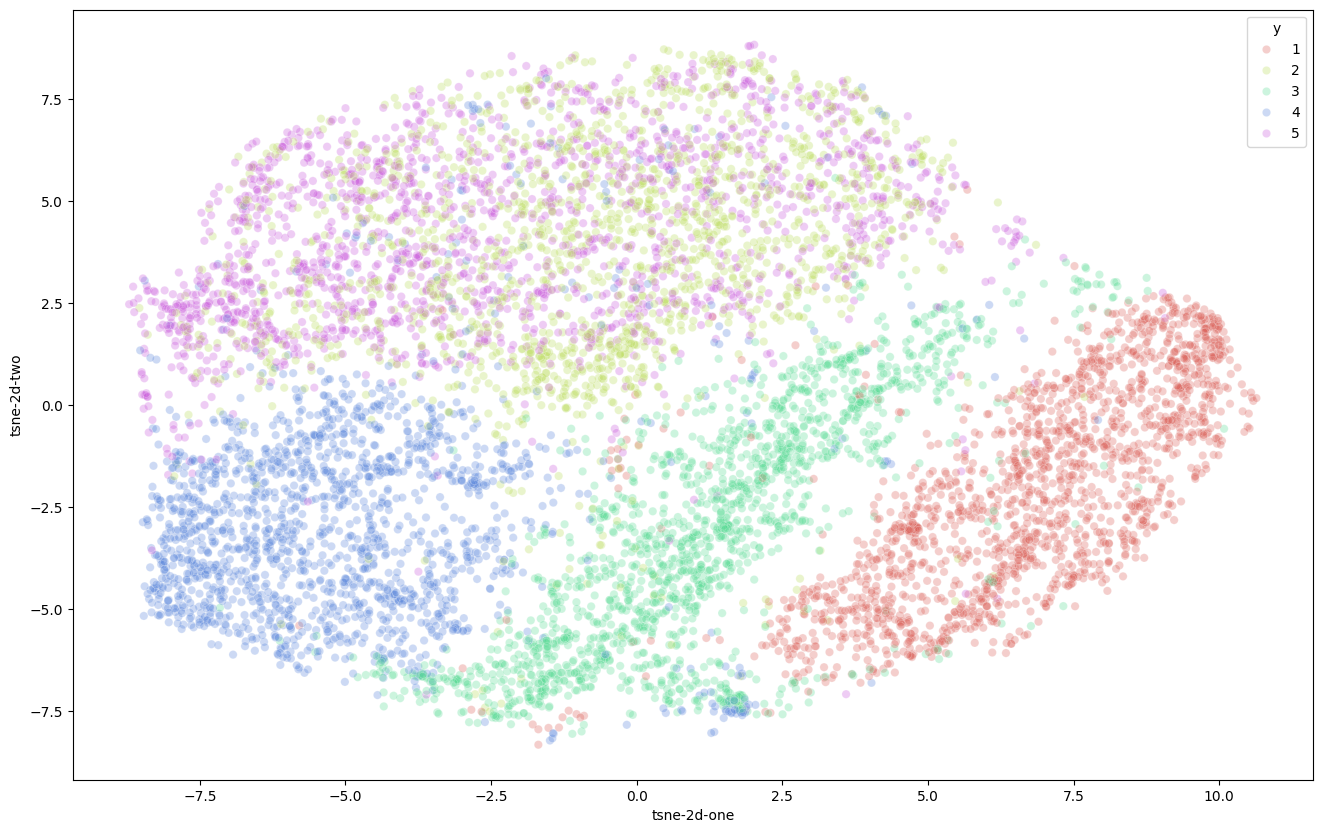

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
# Διαβάζεται το dataset από το αρχείο
low_memory=False
df = pd.read_csv("datasetTV.csv", header = None)
X = df.iloc[:, :-1].values
Y = np.ravel(df.iloc[:,-1:].values)

# Τα δεδομένα επαναφέρονται σε μορφή dataframe ώστε να εφαρμοστούν οι αλγόριθμοι dimensionality reduction
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = Y
df['label'] = df['y'].apply(lambda i: str(i))

X, Y = None, None

# Ορίζεται το data_subset ως οι τιμές του dataframe με τιμές στο feat.cols
data_subset = df[feat_cols].values

# Εφαρμόζεται πρώτα ο αλγόριθμος PCA με όρισμα 0.9, που κρατά τα χαρακτηριστικά μέχρι το variance να ξεπεράσει το 0.9
pca_90 = PCA(0.9)
pca_result_90 = pca_90.fit_transform(data_subset)

# Τέλος εφαρμόζεται ο αλγόριθμος TSNE με τις hyperparameters που φαίνονται
tsne = TSNE(n_components=2, verbose=0, perplexity=40, max_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_90)

# Αποθηκεύουμε τα αποτελέσματα
df['tsne-2d-one'] = tsne_pca_results[:,0]
df['tsne-2d-two'] = tsne_pca_results[:,1]

# Τα παρουσιάζουμε σε scatterplot
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 5),
    data=df,
    legend="full",
    alpha=0.3
)

Παρατηρούμε ότι ο αλγόριθμος καταφέρνει να ξεχωρίσει ικανοποιητικά τις κλάσεις 1, 3 και 4, αλλά παρουσιάζει σημαντικό overlap στις κλάσεις 2 και 5. Δοκιμάζοντας κάποιον ταξινομητή στο σύνολο που προκύπτει (π.χ. K-Nearest_Neighbors) παρατηρούμε κάποια βελτίωση από τα προηγούμενα αποτελέσματα, αλλά όχι τρομερή (η ακρίβεια κυμαίνεται γύρω στο 82%). Δοκιμάζουμε να εφαρμόσουμε τον αλγόριθμο TSNE αλλά με n_components = 3 (το πρόβλημα να μειωθεί δηλαδή σε τρισδιάστατο), ώστε να είναι δυνατή και πάλι η παρουσίαση αλλά να είναι και πιθανό να βελτιωθεί ο χωρισμός μεταξύ των προβληματικών κλάσεων 2 και 5.

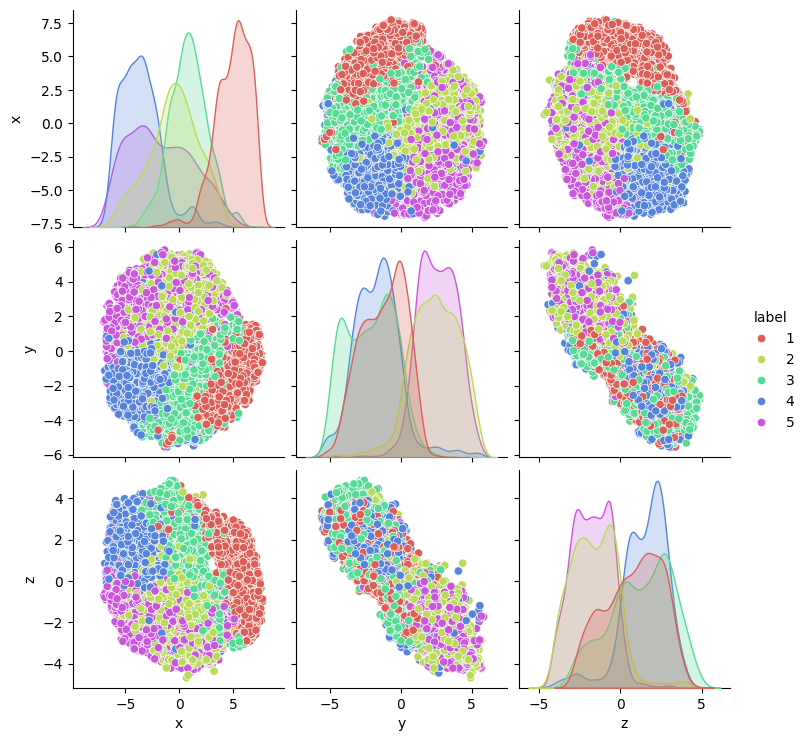

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
# Διαβάζεται το dataset από το αρχείο
low_memory=False
df = pd.read_csv("datasetTV.csv", header = None)
X = df.iloc[:, :-1].values
Y = np.ravel(df.iloc[:,-1:].values)

# Τα δεδομένα επαναφέρονται σε μορφή dataframe ώστε να εφαρμοστούν οι αλγόριθμοι dimensionality reduction
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = Y
df['label'] = df['y'].apply(lambda i: str(i))


# Ορίζεται το data_subset ως οι τιμές του dataframe με τιμές στο feat.cols
data_subset = df[feat_cols].values

# Εφαρμόζεται πρώτα ο αλγόριθμος PCA με όρισμα 0.9, που κρατά τα χαρακτηριστικά μέχρι το variance να ξεπεράσει το 0.9
pca_90 = PCA(0.9)
pca_result_90 = pca_90.fit_transform(data_subset)

# Τέλος εφαρμόζεται ο αλγόριθμος TSNE με τις hyperparameters που φαίνονται
tsne = TSNE(n_components=3, verbose=0, perplexity=40, max_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_90)

# Αποθηκεύουμε τα αποτελέσματα
df_3d = pd.DataFrame()
df_3d['x'] = tsne_pca_results[:,0]
df_3d['y'] = tsne_pca_results[:,1]
df_3d['z'] = tsne_pca_results[:,2]
df_3d['label'] = df['y']

# Τα παρουσιάζουμε σε κατάλληλα plots
sns.pairplot(df_3d, hue='label', palette=sns.color_palette("hls", 5))

Η επικάλυψη των κλάσεων 2 και 5 είναι και πάλι μεγάλη, ακόμα και στις 3 διαστάσεις. Οι ταξινομητές που δοκιμάστηκαν και πάλι δεν παρουσίασαν ιδιαίτερη βελτίωση. Δοκιμάστηκαν στη συνέχεια πιο προχωρημένες στρατηγικές dimensionality reduction. Συγκεκριμένα, ο αλγόριθμος UMAP είναι και αυτός μη γραμμικός, αλλά εστιάζει στη συνολική εικόνα των δεδομένων και όχι στην τοπική, όπως ο TSNE. Προτού τον χρησιμοποιήσουμε, τον εγκαθιστούμε στο workplace τρέχοντας τον παρακάτω κώδικα. Εγκαθιστούμε επίσης τη βιβλιοθήκη optuna που μας επιτρέπει να ορίσουμε και να λύσουμε πιο εύκολα προβλήματα βελτιστοποίησης, όπως είναι το hyperparameter tuning.

In [ ]:
!pip install umap-learn
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel
!pip install --quiet optuna
!pip install --upgrade numba

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 82.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.8 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.29.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.1 MB/s eta 0:00:00
   ━━━━━━

Έχοντας εγκαταστήσει τις βιβλιοθήκες, δοκιμάζουμε τις δυνατότητες του αλγορίθμου UMAP. Συγκεκριμένα, ορίζεται ένα pipeline το οποίο αρχικά μετατρέπει τα δεδομένα (είτε με PowerTransformer είτε με QuantileTransformer) και στη συνέχεια εφαρμόζει τον αλγόριθμο UMAP. Τέλος, προπονείται ένας ταξινομητής RandomForestClassifier με τα μεταμορφωμένα δεδομένα και δοκιμάζεται η ακρίβειά του.

/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Function "cuInit" not found
  warnings.warn(str(e))
/usr/local/lib/python3.10/dist-p

81.42

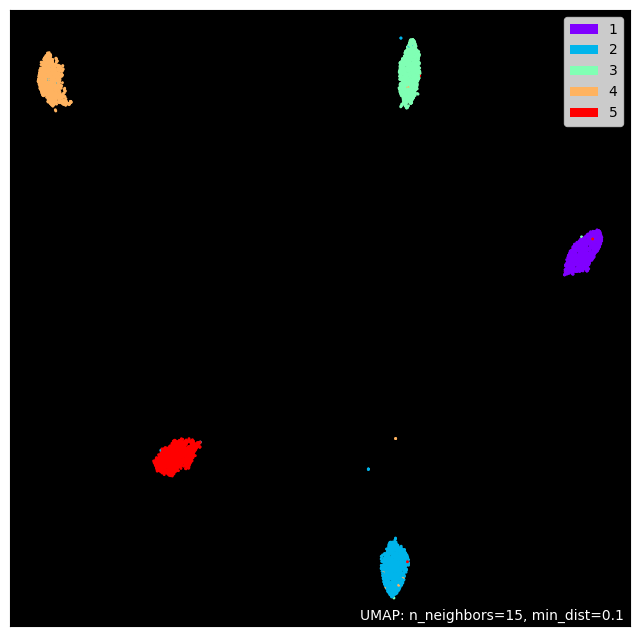

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import umap
import umap.plot
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Διαβάζεται το dataset από το αρχείο
low_memory=False
df = pd.read_csv("datasetTV.csv", header = None)
X = df.iloc[:, :-1].values
Y = np.ravel(df.iloc[:,-1:].values)
# Το dataset χωρίζεται σε training και testing κομμάτι
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                   test_size=0.2,
                                                   random_state=42)
# Δημιουργείται το pipeline με τον αρχικό Transformer και το σύνολο X_train επιδέχεται transformation
pipe = make_pipeline(QuantileTransformer())
X_train = pipe.fit_transform(X_train.copy())

# Ορίζεται ο UMAP που ταιριάζει στο πρόβλημα και παρουσιάζεται το διάγραμμα
manifold = umap.UMAP().fit(X_train, y_train)
umap.plot.points(manifold, labels=y_train, theme="fire");

# Εκπαιδεύεται ο RandomForestClassifier και δοκιμάζεται η ακρίβεια του ταξινομητή
rf = RandomForestClassifier().fit(manifold.embedding_, y_train)
X_test = pipe.transform(X_test.copy())
X_embed = manifold.transform(X_test)
y_pred = rf.predict(X_embed)
acc = accuracy_score(y_test, y_pred)
round(acc * 100, 2)

Ο αλγόριθμος UMAP καταφέρνει στο training set να διαχωρίσει πολύ επιτυχώς τις κλάσεις, αλλά η ακρίβεια παραμένει χαμηλή. Αυτό συμβαίνει διότι ίσως έχει συμβεί overfitting και ο αλγόριθμος δεν ανταπεξέρχεται στα νέα δεδομένα που του προσφέρονται στο testing set. Για να δοκιμαστεί το κατά πόσο υπάρχει περιθώριο βελτίωσης, χρησιμοποιείται η βιβλιοθήκη optuna για να γίνει hyperparameter tuning για όλα τα τμήματα του αλγορίθμου.

In [ ]:
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import umap

# Διαβάζεται το dataset από το αρχείο
low_memory=False
df = pd.read_csv("datasetTV.csv", header = None)
X = df.iloc[:, :-1].values
y = np.ravel(df.iloc[:,-1:].values)

# Το dataset χωρίζεται σε training, validation και testing κομμάτι
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def optimize_pipeline(trial):
    """Objective function to optimize the pipeline using Optuna."""
    # Πρώτα δοκιμάζεται το scaling των δεδομένων
    scaler_option = trial.suggest_categorical("scaler", ["standard", "none"])

    if scaler_option == "standard":
        scaler = StandardScaler()
    else:
        scaler = "passthrough"

    # Εδώ επιλέγονται οι παράμετροι του UMAP
    n_neighbors = trial.suggest_int("n_neighbors", 2, 50)
    min_dist = trial.suggest_float("min_dist", 0.0, 1.0)
    n_components = trial.suggest_int("n_components", 2, X_train.shape[1])

    # Εδώ επιλέγονται οι παράμετροι του RandomForestClassifier
    n_estimators = trial.suggest_int("rf_n_estimators", 10, 200)
    max_depth = trial.suggest_int("rf_max_depth", 2, 20)

    # Δημιουργείται το Pipeline
    pipeline = Pipeline([
        ("scaler", scaler),
        ("umap", umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)),
        ("classifier", RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42))
    ])

    # Ανάλογα με το validation, εκπαιδεύεται το Pipeline που ορίσαμε
    pipeline.fit(X_train, y_train)
    val_score = pipeline.score(X_val, y_val)
    return val_score

# Βελτιστοποίηση του Pipeline
study = optuna.create_study(direction="maximize")
study.optimize(optimize_pipeline, n_trials=50)

# Εκτυπώνεται η καλύτερη δοκιμή
print("Best trial:")
print(study.best_trial)

# Χτίζεται το βέλτιστο Pipeline με τις βέλτιστες παραμέτρους που προέκυψαν
best_params = study.best_trial.params

if best_params["scaler"] == "standard":
    scaler = StandardScaler()
else:
    scaler = "passthrough"

umap_transformer = umap.UMAP(
    n_neighbors=best_params["n_neighbors"],
    min_dist=best_params["min_dist"],
    n_components=best_params["n_components"],
    random_state=42
)

classifier = RandomForestClassifier(
    n_estimators=best_params["rf_n_estimators"],
    max_depth=best_params["rf_max_depth"],
    random_state=42
)

# Ορίζεται το τελικό Pipeline
final_pipeline = Pipeline([
    ("scaler", scaler),
    ("umap", umap_transformer),
    ("classifier", classifier)
])

# Εκπαιδεύεται το Pipeline και δοκιμάζεται στο testing set
final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))

[I 2025-01-01 18:02:16,953] A new study created in memory with name: no-name-fa79c625-6b6f-4a3c-b9fa-584dbcaeb116
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-01 18:03:46,771] Trial 0 finished with value: 0.79073756432247 and parameters: {'scaler': 'none', 'n_neighbors': 4, 'min_dis

Best trial:
FrozenTrial(number=27, state=TrialState.COMPLETE, values=[0.8467695826186392], datetime_start=datetime.datetime(2025, 1, 1, 18, 25, 25, 216537), datetime_complete=datetime.datetime(2025, 1, 1, 18, 26, 25, 746623), params={'scaler': 'none', 'n_neighbors': 10, 'min_dist': 0.7976168554551606, 'n_components': 223, 'rf_n_estimators': 128, 'rf_max_depth': 20}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'scaler': CategoricalDistribution(choices=('standard', 'none')), 'n_neighbors': IntDistribution(high=50, log=False, low=2, step=1), 'min_dist': FloatDistribution(high=1.0, log=False, low=0.0, step=None), 'n_components': IntDistribution(high=224, log=False, low=2, step=1), 'rf_n_estimators': IntDistribution(high=200, log=False, low=10, step=1), 'rf_max_depth': IntDistribution(high=20, log=False, low=2, step=1)}, trial_id=27, value=None)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Test accuracy: 0.8393367638650657


Το Pipeline που δημιουργήσαμε έχει ακρίβεια 84% στο testing set, μία σίγουρη βελτίωση, αλλά ίσως όχι αρκετή. Μάλιστα, παρατηρούμε ότι ο βέλτιστος αριθμός n_components του UMAP είναι 223 (αρχικά ήταν 224), άρα πιθανότατα η τακτική dimensionality reduction δεν είναι και ιδιαίτερα σωστή. Μεταβάλλουμε λοιπόν τη προσέγγισή μας και δοκιμάζουμε προχωρημένους ταξινομητές βασισμένους στη λογική των RandomForestClassifiers, οι οποίοι μέχρι τώρα παρουσιάζουν την υψηλότερη ακρίβεια. Συγκεκριμένα, δοκιμάζονται οι ταξινομητές XGBoost και LightGBM, οι οποίοι πρέπει πρώτα να εγκατασταθούν στο περιβάλλον.

In [ ]:
!pip install xgboost lightgbm

Δοκιμάζονται οι δύο νέοι Classifiers.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler

# Διαβάζεται το dataset από το αρχείο
low_memory=False
df = pd.read_csv("datasetTV.csv", header = None)
X = df.iloc[:, :-1].values
Y = np.ravel(df.iloc[:,-1:].values)
Y = Y - 1 # Οι ταξινομητές δέχονται κλάσεις με τιμές από 0 έως 4 και όχι από 1 έως 5

# Το dataset χωρίζεται σε training, validation και testing κομμάτι
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=42)
# Κάνουμε scaling τα δεδομένα
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Εκπαιδεύουμε τον ταξινομητή XGΒ
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_scaled, y_train)

# Προβλέπουμε
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Παρουσιάζουμε τα αποτελέσματα
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

# Εκπαιδεύουμε τον ταξινομητή LGBM
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_scaled, y_train)

# Προβλέπουμε
y_pred_lgbm = lgbm_model.predict(X_test_scaled)

# Παρουσιάζουμε τα αποτελέσματα
print("LightGBM Accuracy:", accuracy_score(y_test, y_pred_lgbm))
print("LightGBM Classification Report:\n", classification_report(y_test, y_pred_lgbm))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [18:26:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8404802744425386
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       377
           1       0.71      0.69      0.70       332
           2       0.92      0.90      0.91       349
           3       0.88      0.88      0.88       325
           4       0.74      0.75      0.74       366

    accuracy                           0.84      1749
   macro avg       0.84      0.84      0.84      1749
weighted avg       0.84      0.84      0.84      1749



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.614311
[LightGBM] [Info] Start training from score -1.617189
[LightGBM] [Info] Start training from score -1.605015
[LightGBM] [Info] Start training from score -1.615030
[LightGBM] [Info] Start training from score -1.595805
LightGBM Accuracy: 0.8484848484848485
LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96       377
           1       0.71      0.71      0.71       332
           2       0.92      0.92      0.92       349
           3       0.89      0.87      0.88       325
           4       0.75      0.77      0.76       366

    accuracy                           0.85

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Ήδη χωρίς parameter tuning, τα αποτελέσματα είναι σχεδόν όμοια με όλη την προηγούμενη διαδικασία. Η ακρίβεια κυμαίνεται από 84 έως 85% και υπάρχει βελτιωμένη διάκριση μεταξύ των προβληματικών κλάσεων 2 και 5. Ακολουθεί parameter tuning του LGBM ως παράδειγμα.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Διαβάζεται το dataset από το αρχείο
low_memory=False
df = pd.read_csv("datasetTV.csv", header = None)
X = df.iloc[:, :-1].values
Y = np.ravel(df.iloc[:,-1:].values)
Y = Y - 1 # Ο ταξινομητής δέχεται κλάσεις με τιμές από 0 έως 4 και όχι από 1 έως 5

# Το dataset χωρίζεται σε training, validation και testing κομμάτι
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=42)

# Κάνουμε scaling τα δεδομένα
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def tune_model(model, param_grid):
  # Ορίζουμε το GridSearchCV()
  grid_search = GridSearchCV(model,
                             param_grid,
                             cv=5 # Cross validation με Κ=5
                             )

  # Το μοντέλο μας θα τρέξει K=5 φορές για κάθε πιθανό συνδυασμό υπερπαραμέτρων
  grid_search.fit(X_train_scaled, y_train)

  # Όταν τελειώσει η διαδικασία μπορούμε να ανακτήσουμε τον συνδυασμό υπερ-παραμέτρων που δίνουν την καλύτερη απόδοση βάσει του cross validation process
  print(f"Best parameters: {grid_search.best_params_}")

  # Μπορούμε να ανακτήσουμε το μοντέλο με την καλύτερη απόδοση (βάσει του Cross Validation)

  best_model = grid_search.best_estimator_

  # Και μετά να κάνουμε αξιολόγηση στο τελικό testing set
  y_pred = best_model.predict(X_test_scaled)
  acc = accuracy_score(y_test, y_pred)



  return round(acc * 100, 2)

lgbm_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1],
    'max_depth': [7, 10],
    'num_leaves': [31, 63],
    'min_child_samples': [1, 5]
}

lgbm = LGBMClassifier(random_state=42)

lgbm_acc= tune_model(lgbm, lgbm_param_grid)

print("After tuning, LGBM accuracy: ", lgbm_acc)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_m

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014987 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012354 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033976 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020822 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016719 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.616613
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.615713
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.595241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5595, number of used features: 224
[LightGBM] [Info] Start training from score -1.613916
[LightGBM] [Info] Start training from score -1.617513
[LightGBM] [Info] Start training from score -1.604980
[LightGBM] [Info] Start training from score -1.614814
[LightGBM] [Info] Start training from score -1.596122
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 5596, number of used features: 224
[LightGBM] [Info] Start training from score -1.614095
[LightGBM] [Info] Start training from score -1.616792
[LightGBM] [Info] Start training from score -1.605158
[LightGBM] [Info] Start training from score -1.614993
[LightGBM] [Info] Start training from score -1.596301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.614311
[LightGBM] [Info] Start training from score -1.617189
[LightGBM] [Info] Start training from score -1.605015
[LightGBM] [Info] Start training from score -1.615030
[LightGBM] [Info] Start training from score -1.595805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Ο βέλτιστος LGBM έχει ακρίβεια 84.73. Δοκιμάζουμε μία λίγο διαφορετική προσέγγιση: Κρατούμε τον multi-class classifier ίδιο, αλλά δημιουργούμε έναν ακόμα binary classifier που είναι ειδικό στο να διαχωρίζει μετακύ των προβληματικών κλάσεων 2 και 5. Εάν ο multi-class classifier αποφασίσει 2 ή 5, χρησιμοποιείται ο ειδικός binary classifier για να αποφασιστεί αν θα κρατηθεί το αποτέλεσμα 2 ή 5. Ο binary classifier αυτός επιλέγουμε να είναι ίδιου τύπου με τον multi-class classifier.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from xgboost import XGBClassifier

# Διαβάζεται το dataset από το αρχείο
low_memory=False
df = pd.read_csv("datasetTV.csv", header = None)
X = df.iloc[:, :-1].values
Y = np.ravel(df.iloc[:,-1:].values)
Y = Y - 1 # Ο ταξινομητής δέχεται κλάσεις με τιμές από 0 έως 4 και όχι από 1 έως 5

# Το dataset χωρίζεται σε training και testing κομμάτι
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

### Στάδιο 1: Multi-Class XGBoost Classifier ###
multi_class_model = XGBClassifier(
    objective="multi:softmax",  # Multi-class classification
    num_class=5,               # Αριθμός κλάσεων
    eval_metric="mlogloss",    # Evaluation metric
    use_label_encoder=False,
    random_state=42
)

# Εκπαιδεύεται ο Multi-class classifier
multi_class_model.fit(X_train, y_train)

# Προβλέψεις μετά το πρώτο στάδιο
y_pred_stage1 = multi_class_model.predict(X_test)

# Φίλτρο για τις προβληματικές κλάσεις
problematic_indices = np.where((y_pred_stage1 == 1) | (y_pred_stage1 == 4))[0] # Θυμόμαστε ότι οι προβληματικές κλάσεις είναι οι 2 και 5, οπότε μετά τη μετατροπή Y = Y - 1 οι κλάσεις 1 και 4
X_problematic = X_test[problematic_indices]
y_problematic = y_test[problematic_indices]

# Αν δεν υπάρχουν προβληματικά δείγματα, συνεχίζουμε
if len(X_problematic) == 0:
    print("No problematic samples detected by Stage 1. Exiting.")
    exit()

### Στάδιο 2: Binary XGBoost Classifier for Problematic Classes ###
# Φίλτρο για τα training data του binary classifier
problematic_train_indices = np.where((y_train == 1) | (y_train == 4))[0] # Θυμόμαστε ότι οι προβληματικές κλάσεις είναι οι 2 και 5, οπότε μετά τη μετατροπή Y = Y - 1 οι κλάσεις 1 και 4
X_binary_train = X_train[problematic_train_indices]
y_binary_train = y_train[problematic_train_indices]

# Εκπαιδεύεται ο binary classifier
binary_model = XGBClassifier(
    objective="binary:logistic",  # Binary classification
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Μετατρέπουμε τα δεδομένα σε κλάσεις 0 και 1, διότι αυτές δέχεται ο ταξινομητής
y_binary_train_transformed = np.where(y_binary_train == 1, 0, 1)
binary_model.fit(X_binary_train, y_binary_train_transformed)

# Προβλέψεις του σταδίου 2
y_pred_stage2 = binary_model.predict(X_problematic)
y_pred_stage2 = np.where(y_pred_stage2 == 0, 1, 4)

# Αντικαθιστούμε τις προβλέψεις του σταδίου 1 με τις προβλέψεις του σταδίου 2 για τις προβληματικές κλάσεις
y_pred_combined = y_pred_stage1.copy()
y_pred_combined[problematic_indices] = y_pred_stage2

### Αξιολόγηση των αποτελεσμάτων ###
print("Combined Classifier Results:")
print(classification_report(y_test, y_pred_combined))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_combined))
print("Accuracy:")
print(accuracy_score(y_test, y_pred_combined))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:22:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [01:23:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Combined Classifier Results:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       354
           1       0.75      0.70      0.73       344
           2       0.93      0.93      0.93       351
           3       0.93      0.90      0.92       343
           4       0.72      0.77      0.74       357

    accuracy                           0.86      1749
   macro avg       0.86      0.86      0.86      1749
weighted avg       0.86      0.86      0.86      1749

Confusion Matrix:
[[346   2   4   1   1]
 [  1 242   8   5  88]
 [ 10   2 325   9   5]
 [  2   7  11 308  15]
 [  5  69   1   7 275]]
Accuracy:
0.8553459119496856


Η ακρίβεια είναι 85.5%. Ακολουθεί η ίδια τακτική για τον LightGBM.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from lightgbm import LGBMClassifier

# Διαβάζεται το dataset από το αρχείο
low_memory=False
df = pd.read_csv("datasetTV.csv", header = None)
X = df.iloc[:, :-1].values
Y = np.ravel(df.iloc[:,-1:].values)
Y = Y - 1 # Ο ταξινομητής δέχεται κλάσεις με τιμές από 0 έως 4 και όχι από 1 έως 5

# Το dataset χωρίζεται σε training και testing κομμάτι
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

### Στάδιο 1: Multi-Class XGBoost Classifier ###
multi_class_model = LGBMClassifier(
    objective="multiclass",  # Multi-class classification
    num_class=5,             # Αριθμός κλάσεων
    random_state=42
)

# Εκπαιδεύεται ο Multi-class classifier
multi_class_model.fit(X_train, y_train)

# Προβλέψεις μετά το πρώτο στάδιο
y_pred_stage1 = multi_class_model.predict(X_test)

# Φίλτρο για τις προβληματικές κλάσεις
problematic_indices = np.where((y_pred_stage1 == 1) | (y_pred_stage1 == 4))[0] # Θυμόμαστε ότι οι προβληματικές κλάσεις είναι οι 2 και 5, οπότε μετά τη μετατροπή Y = Y - 1 οι κλάσεις 1 και 4
X_problematic = X_test[problematic_indices]
y_problematic = y_test[problematic_indices]

# Αν δεν υπάρχουν προβληματικά δείγματα, συνεχίζουμε
if len(X_problematic) == 0:
    print("No problematic samples detected by Stage 1. Exiting.")
    exit()

### Στάδιο 2: Binary XGBoost Classifier for Problematic Classes ###
# Φίλτρο για τα training data του binary classifier
problematic_train_indices = np.where((y_train == 1) | (y_train == 4))[0] # Θυμόμαστε ότι οι προβληματικές κλάσεις είναι οι 2 και 5, οπότε μετά τη μετατροπή Y = Y - 1 οι κλάσεις 1 και 4
X_binary_train = X_train[problematic_train_indices]
y_binary_train = y_train[problematic_train_indices]

# Ορίζεται ο binary classifier
binary_model = LGBMClassifier(
    objective="binary",  # Binary classification
    random_state=42
)

# Μετατρέπουμε τα δεδομένα σε κλάσεις 0 και 1, διότι αυτές δέχεται ο ταξινομητής
y_binary_train_transformed = np.where(y_binary_train == 1, 0, 1)
binary_model.fit(X_binary_train, y_binary_train_transformed)

# Προβλέψεις του σταδίου 2
y_pred_stage2 = binary_model.predict(X_problematic)
y_pred_stage2 = np.where(y_pred_stage2 == 0, 1, 4)

# Αντικαθιστούμε τις προβλέψεις του σταδίου 1 με τις προβλέψεις του σταδίου 2 για τις προβληματικές κλάσεις
y_pred_combined = y_pred_stage1.copy()
y_pred_combined[problematic_indices] = y_pred_stage2

### Αξιολόγηση των αποτελεσμάτων ###
print("Combined Classifier Results:")
print(classification_report(y_test, y_pred_combined))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_combined))
print("Accuracy:")
print(accuracy_score(y_test, y_pred_combined))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
Combined Classifier Results:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       354
           1       0.77      0.70      0.73       344
           2       0.93      0.92      0.92       351
           3       0.92      0.88      0.90       343
           4       0.70      0.78      0.74       357

    accuracy                           0.85      1749
   macro avg       0.86      0.85      0.85      1749
weighted avg       0.86      0.85      0.85   

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Η ακρίβεια είναι 85.3% . Παρατηρούμε υψηλή ακρίβεια ήδη χωρίς hyperparameter tuning. Επειδή είναι γενικά πιο ταχύς και τα αποτελέσματα είναι παρόμοια, επιλέγεται ο LightGBM classifier.

In [ ]:
import numpy as np
import pandas as pd
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier

# Διαβάζεται το dataset από το αρχείο
low_memory=False
df = pd.read_csv("datasetTV.csv", header = None)
X = df.iloc[:, :-1].values
y = np.ravel(df.iloc[:,-1:].values)
y = y - 1 # Ο ταξινομητής δέχεται κλάσεις με τιμές από 0 έως 4 και όχι από 1 έως 5

# Το dataset χωρίζεται σε training και testing κομμάτι
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Ορίζεται η συνάρτηση βελτιστοποίησης με optuna
def objective(trial):
    # Παράμετροι του Multi-Class Classifier
    multi_num_leaves = trial.suggest_int("multi_num_leaves", 20, 150)
    multi_max_depth = trial.suggest_int("multi_max_depth", 3, 15)
    multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)

    # Παράμετροι του Binary Classifier
    binary_num_leaves = trial.suggest_int("binary_num_leaves", 20, 150)
    binary_max_depth = trial.suggest_int("binary_max_depth", 3, 15)
    binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)

    ### Στάδιο 1: Multi-Class Classifier ###
    multi_class_model = LGBMClassifier(
        objective="multiclass",
        num_class=5,
        num_leaves=multi_num_leaves,
        max_depth=multi_max_depth,
        learning_rate=multi_learning_rate,
        random_state=42
    )

    # Εκπαιδεύεται ο Multi-class classifier
    multi_class_model.fit(X_train, y_train)
    y_pred_stage1 = multi_class_model.predict(X_test)

    # Βρίσκονται οι προβληματικές κλάσεις
    problematic_indices = np.where((y_pred_stage1 == 1) | (y_pred_stage1 == 4))[0] # Θυμόμαστε ότι οι προβληματικές κλάσεις είναι οι 2 και 5, οπότε μετά τη μετατροπή Y = Y - 1 οι κλάσεις 1 και 4
    X_problematic = X_test[problematic_indices]
    y_problematic = y_test[problematic_indices]

    # Αν δεν υπάρχουν προβληματικά δείγματα, συνεχίζουμε
    if len(problematic_indices) == 0:
        return accuracy_score(y_test, y_pred_stage1)

    ### Στάδιο 2: Binary Classifier ###
    # Προετοιμασία των δεδομένων για τον Binary Classifier, όπως έγινε και παραπάνω
    problematic_train_indices = np.where((y_train == 1) | (y_train == 4))[0] # Θυμόμαστε ότι οι προβληματικές κλάσεις είναι οι 2 και 5, οπότε μετά τη μετατροπή Y = Y - 1 οι κλάσεις 1 και 4
    X_binary_train = X_train[problematic_train_indices]
    y_binary_train = y_train[problematic_train_indices]
    y_binary_train_transformed = np.where(y_binary_train == 1, 0, 1)
    y_problematic_transformed = np.where(y_problematic == 1, 0, 1)

    binary_model = LGBMClassifier(
        objective="binary",
        num_leaves=binary_num_leaves,
        max_depth=binary_max_depth,
        learning_rate=binary_learning_rate,
        random_state=42
    )

    # Εκπαιδεύεται ο Binary classifier
    binary_model.fit(X_binary_train, y_binary_train_transformed)
    y_pred_stage2 = binary_model.predict(X_problematic)

    # Αντικαθιστούμε τις προβλέψεις του σταδίου 1 με τις προβλέψεις του σταδίου 2 για τις προβληματικές κλάσεις
    y_pred_combined = y_pred_stage1.copy()
    y_pred_combined[problematic_indices] = np.where(y_pred_stage2 == 0, 1, 4)

    # Υπολογίζεται η τελική ακρίβεια
    return accuracy_score(y_test, y_pred_combined)

# Τρέχεται ο αλγόριθμος βελτιστοποίησης
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

# Επιστρέφονται οι βέλτιστες παράμετροι και η καλύτερη ακρίβεια
print("Best Parameters:")
print(study.best_params)
print("Best Accuracy:", study.best_value)

[I 2025-01-03 15:51:39,659] A new study created in memory with name: no-name-f843fb2d-8817-4948-9a07-6613d3af9c68
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.069347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:52:18,231] Trial 0 finished with value: 0.8427672955974843 and parameters: {'multi_num_leaves': 54, 'multi_max_depth': 6, 'multi_learning_rate': 0.039411849290685204, 'binary_num_leaves': 93, 'binary_max_depth': 15, 'binary_learning_rate': 0.024903036537940928}. Best is trial 0 with value: 0.8427672955974843.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:53:28,667] Trial 1 finished with value: 0.8158947970268725 and parameters: {'multi_num_leaves': 139, 'multi_max_depth': 10, 'multi_learning_rate': 0.05143079394836898, 'binary_num_leaves': 110, 'binary_max_depth': 10, 'binary_learning_rate': 0.001265510776369944}. Best is trial 0 with value: 0.8427672955974843.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:54:37,218] Trial 2 finished with value: 0.7838765008576329 and parameters: {'multi_num_leaves': 126, 'multi_max_depth': 14, 'multi_learning_rate': 0.0014639058354904467, 'binary_num_leaves': 64, 'binary_max_depth': 13, 'binary_learning_rate': 0.03867694248354184}. Best is trial 0 with value: 0.8427672955974843.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:54:58,468] Trial 3 finished with value: 0.8393367638650657 and parameters: {'multi_num_leaves': 37, 'multi_max_depth': 5, 'multi_learning_rate': 0.0407050104616871, 'binary_num_leaves': 70, 'binary_max_depth': 9, 'binary_learning_rate': 0.017343940540959377}. Best is trial 0 with value: 0.8427672955974843.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://githu

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010968 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:55:14,781] Trial 4 finished with value: 0.7930245854774156 and parameters: {'multi_num_leaves': 112, 'multi_max_depth': 5, 'multi_learning_rate': 0.0034482009504500687, 'binary_num_leaves': 108, 'binary_max_depth': 4, 'binary_learning_rate': 0.04415161163068504}. Best is trial 0 with value: 0.8427672955974843.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024577 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:55:41,313] Trial 5 finished with value: 0.8524871355060034 and parameters: {'multi_num_leaves': 30, 'multi_max_depth': 14, 'multi_learning_rate': 0.05160482927373097, 'binary_num_leaves': 37, 'binary_max_depth': 14, 'binary_learning_rate': 0.0571662817237476}. Best is trial 5 with value: 0.8524871355060034.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gith

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:56:13,417] Trial 6 finished with value: 0.8096054888507719 and parameters: {'multi_num_leaves': 43, 'multi_max_depth': 15, 'multi_learning_rate': 0.0048728861629306055, 'binary_num_leaves': 48, 'binary_max_depth': 11, 'binary_learning_rate': 0.03142037944853033}. Best is trial 5 with value: 0.8524871355060034.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:56:56,271] Trial 7 finished with value: 0.7975986277873071 and parameters: {'multi_num_leaves': 78, 'multi_max_depth': 10, 'multi_learning_rate': 0.0033335314368314654, 'binary_num_leaves': 26, 'binary_max_depth': 6, 'binary_learning_rate': 0.023578321991358495}. Best is trial 5 with value: 0.8524871355060034.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:57:12,119] Trial 8 finished with value: 0.7632933104631218 and parameters: {'multi_num_leaves': 114, 'multi_max_depth': 4, 'multi_learning_rate': 0.0027583103813910563, 'binary_num_leaves': 64, 'binary_max_depth': 11, 'binary_learning_rate': 0.014202951928485306}. Best is trial 5 with value: 0.8524871355060034.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:57:31,791] Trial 9 finished with value: 0.7993138936535163 and parameters: {'multi_num_leaves': 74, 'multi_max_depth': 5, 'multi_learning_rate': 0.00402516673126532, 'binary_num_leaves': 49, 'binary_max_depth': 10, 'binary_learning_rate': 0.05778075062832389}. Best is trial 5 with value: 0.8524871355060034.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gith

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:57:57,096] Trial 10 finished with value: 0.8021726700971984 and parameters: {'multi_num_leaves': 20, 'multi_max_depth': 12, 'multi_learning_rate': 0.015429797859623447, 'binary_num_leaves': 129, 'binary_max_depth': 15, 'binary_learning_rate': 0.004712064681369921}. Best is trial 5 with value: 0.8524871355060034.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:58:34,731] Trial 11 finished with value: 0.8496283590623214 and parameters: {'multi_num_leaves': 51, 'multi_max_depth': 8, 'multi_learning_rate': 0.020395531102756017, 'binary_num_leaves': 91, 'binary_max_depth': 15, 'binary_learning_rate': 0.07790605430179572}. Best is trial 5 with value: 0.8524871355060034.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:58:59,659] Trial 12 finished with value: 0.8570611778158947 and parameters: {'multi_num_leaves': 22, 'multi_max_depth': 8, 'multi_learning_rate': 0.09387328395623278, 'binary_num_leaves': 20, 'binary_max_depth': 13, 'binary_learning_rate': 0.08454850164430873}. Best is trial 12 with value: 0.8570611778158947.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:59:20,625] Trial 13 finished with value: 0.8604917095483133 and parameters: {'multi_num_leaves': 24, 'multi_max_depth': 13, 'multi_learning_rate': 0.08402820430650662, 'binary_num_leaves': 23, 'binary_max_depth': 13, 'binary_learning_rate': 0.08855835907181507}. Best is trial 13 with value: 0.8604917095483133.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 15:59:59,720] Trial 14 finished with value: 0.8364779874213837 and parameters: {'multi_num_leaves': 69, 'multi_max_depth': 8, 'multi_learning_rate': 0.08403821957643803, 'binary_num_leaves': 22, 'binary_max_depth': 12, 'binary_learning_rate': 0.005766546101928027}. Best is trial 13 with value: 0.8604917095483133.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:00:22,938] Trial 15 finished with value: 0.8633504859919954 and parameters: {'multi_num_leaves': 24, 'multi_max_depth': 12, 'multi_learning_rate': 0.08140887590279523, 'binary_num_leaves': 41, 'binary_max_depth': 8, 'binary_learning_rate': 0.08465631866637047}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014856 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:01:17,264] Trial 16 finished with value: 0.8250428816466552 and parameters: {'multi_num_leaves': 97, 'multi_max_depth': 12, 'multi_learning_rate': 0.021508406202470506, 'binary_num_leaves': 43, 'binary_max_depth': 7, 'binary_learning_rate': 0.007886852150993962}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:01:58,680] Trial 17 finished with value: 0.79073756432247 and parameters: {'multi_num_leaves': 61, 'multi_max_depth': 12, 'multi_learning_rate': 0.00740335610649635, 'binary_num_leaves': 144, 'binary_max_depth': 8, 'binary_learning_rate': 0.002611334520571738}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:02:47,660] Trial 18 finished with value: 0.8490566037735849 and parameters: {'multi_num_leaves': 88, 'multi_max_depth': 13, 'multi_learning_rate': 0.028385038241091794, 'binary_num_leaves': 76, 'binary_max_depth': 3, 'binary_learning_rate': 0.09704330378891879}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:03:16,264] Trial 19 finished with value: 0.819325328759291 and parameters: {'multi_num_leaves': 41, 'multi_max_depth': 10, 'multi_learning_rate': 0.011257680007110065, 'binary_num_leaves': 33, 'binary_max_depth': 5, 'binary_learning_rate': 0.015060190283007467}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:03:45,324] Trial 20 finished with value: 0.8599199542595769 and parameters: {'multi_num_leaves': 35, 'multi_max_depth': 11, 'multi_learning_rate': 0.07273710010897456, 'binary_num_leaves': 59, 'binary_max_depth': 7, 'binary_learning_rate': 0.058659967472215885}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:04:11,879] Trial 21 finished with value: 0.8593481989708405 and parameters: {'multi_num_leaves': 30, 'multi_max_depth': 12, 'multi_learning_rate': 0.06871556685803855, 'binary_num_leaves': 53, 'binary_max_depth': 7, 'binary_learning_rate': 0.059161789779783175}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:04:32,402] Trial 22 finished with value: 0.8553459119496856 and parameters: {'multi_num_leaves': 20, 'multi_max_depth': 11, 'multi_learning_rate': 0.0988643274903265, 'binary_num_leaves': 53, 'binary_max_depth': 8, 'binary_learning_rate': 0.09978749904660203}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.036097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:05:08,705] Trial 23 finished with value: 0.8542024013722127 and parameters: {'multi_num_leaves': 51, 'multi_max_depth': 14, 'multi_learning_rate': 0.059834643723305055, 'binary_num_leaves': 34, 'binary_max_depth': 6, 'binary_learning_rate': 0.04026929783974047}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:05:36,953] Trial 24 finished with value: 0.8542024013722127 and parameters: {'multi_num_leaves': 32, 'multi_max_depth': 11, 'multi_learning_rate': 0.03894655651226559, 'binary_num_leaves': 61, 'binary_max_depth': 9, 'binary_learning_rate': 0.0645569459315651}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:06:19,801] Trial 25 finished with value: 0.8399085191538022 and parameters: {'multi_num_leaves': 61, 'multi_max_depth': 13, 'multi_learning_rate': 0.029025279964532788, 'binary_num_leaves': 82, 'binary_max_depth': 8, 'binary_learning_rate': 0.025320504373514217}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035633 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:06:52,238] Trial 26 finished with value: 0.858776443682104 and parameters: {'multi_num_leaves': 42, 'multi_max_depth': 15, 'multi_learning_rate': 0.07165134643128553, 'binary_num_leaves': 40, 'binary_max_depth': 6, 'binary_learning_rate': 0.04702064308890118}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021677 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:07:17,270] Trial 27 finished with value: 0.8507718696397941 and parameters: {'multi_num_leaves': 30, 'multi_max_depth': 9, 'multi_learning_rate': 0.03202624866548123, 'binary_num_leaves': 30, 'binary_max_depth': 10, 'binary_learning_rate': 0.07200398071921399}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:08:32,538] Trial 28 finished with value: 0.8473413379073756 and parameters: {'multi_num_leaves': 150, 'multi_max_depth': 13, 'multi_learning_rate': 0.05604248501589365, 'binary_num_leaves': 42, 'binary_max_depth': 7, 'binary_learning_rate': 0.03303542402490662}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:09:09,870] Trial 29 finished with value: 0.8444825614636935 and parameters: {'multi_num_leaves': 57, 'multi_max_depth': 11, 'multi_learning_rate': 0.045372251760902906, 'binary_num_leaves': 57, 'binary_max_depth': 4, 'binary_learning_rate': 0.02112479309848787}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:09:45,793] Trial 30 finished with value: 0.8187535734705546 and parameters: {'multi_num_leaves': 48, 'multi_max_depth': 9, 'multi_learning_rate': 0.013429274074034192, 'binary_num_leaves': 72, 'binary_max_depth': 11, 'binary_learning_rate': 0.011161608205496732}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021852 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:10:12,685] Trial 31 finished with value: 0.8633504859919954 and parameters: {'multi_num_leaves': 30, 'multi_max_depth': 12, 'multi_learning_rate': 0.06765666530069316, 'binary_num_leaves': 52, 'binary_max_depth': 7, 'binary_learning_rate': 0.05511779340961469}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:10:41,265] Trial 32 finished with value: 0.8604917095483133 and parameters: {'multi_num_leaves': 35, 'multi_max_depth': 11, 'multi_learning_rate': 0.07244690916272147, 'binary_num_leaves': 30, 'binary_max_depth': 9, 'binary_learning_rate': 0.052547594204368366}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:11:05,043] Trial 33 finished with value: 0.8250428816466552 and parameters: {'multi_num_leaves': 26, 'multi_max_depth': 13, 'multi_learning_rate': 0.09576969558463962, 'binary_num_leaves': 28, 'binary_max_depth': 9, 'binary_learning_rate': 0.0010454745584740305}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:11:35,357] Trial 34 finished with value: 0.8530588907947398 and parameters: {'multi_num_leaves': 38, 'multi_max_depth': 10, 'multi_learning_rate': 0.042929438869003717, 'binary_num_leaves': 45, 'binary_max_depth': 9, 'binary_learning_rate': 0.031709876287031855}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009009 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:12:09,956] Trial 35 finished with value: 0.858776443682104 and parameters: {'multi_num_leaves': 47, 'multi_max_depth': 14, 'multi_learning_rate': 0.06368910637910168, 'binary_num_leaves': 21, 'binary_max_depth': 8, 'binary_learning_rate': 0.04499966190380796}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:12:34,304] Trial 36 finished with value: 0.7524299599771298 and parameters: {'multi_num_leaves': 29, 'multi_max_depth': 12, 'multi_learning_rate': 0.0018185866835293306, 'binary_num_leaves': 34, 'binary_max_depth': 12, 'binary_learning_rate': 0.0021382612419518837}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035911 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:13:07,746] Trial 37 finished with value: 0.8542024013722127 and parameters: {'multi_num_leaves': 37, 'multi_max_depth': 14, 'multi_learning_rate': 0.03677295301470257, 'binary_num_leaves': 100, 'binary_max_depth': 10, 'binary_learning_rate': 0.07332813588644815}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021773 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:13:39,949] Trial 38 finished with value: 0.7650085763293311 and parameters: {'multi_num_leaves': 65, 'multi_max_depth': 7, 'multi_learning_rate': 0.0010969100258136073, 'binary_num_leaves': 27, 'binary_max_depth': 5, 'binary_learning_rate': 0.04832975834712716}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:14:04,043] Trial 39 finished with value: 0.8387650085763293 and parameters: {'multi_num_leaves': 25, 'multi_max_depth': 15, 'multi_learning_rate': 0.021237446603679714, 'binary_num_leaves': 38, 'binary_max_depth': 14, 'binary_learning_rate': 0.0989883375067362}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033936 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:14:16,378] Trial 40 finished with value: 0.8279016580903373 and parameters: {'multi_num_leaves': 103, 'multi_max_depth': 3, 'multi_learning_rate': 0.051439171443672736, 'binary_num_leaves': 66, 'binary_max_depth': 9, 'binary_learning_rate': 0.034415367355504885}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:14:45,503] Trial 41 finished with value: 0.8627787307032591 and parameters: {'multi_num_leaves': 35, 'multi_max_depth': 11, 'multi_learning_rate': 0.06613258786813973, 'binary_num_leaves': 50, 'binary_max_depth': 7, 'binary_learning_rate': 0.05403386190492422}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:15:20,536] Trial 42 finished with value: 0.8576329331046312 and parameters: {'multi_num_leaves': 45, 'multi_max_depth': 10, 'multi_learning_rate': 0.07738748596055753, 'binary_num_leaves': 51, 'binary_max_depth': 8, 'binary_learning_rate': 0.05109465113987879}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:15:48,253] Trial 43 finished with value: 0.8513436249285306 and parameters: {'multi_num_leaves': 34, 'multi_max_depth': 11, 'multi_learning_rate': 0.0544832302779557, 'binary_num_leaves': 47, 'binary_max_depth': 6, 'binary_learning_rate': 0.02671888140249621}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:16:08,801] Trial 44 finished with value: 0.8096054888507719 and parameters: {'multi_num_leaves': 25, 'multi_max_depth': 13, 'multi_learning_rate': 0.007602038075363488, 'binary_num_leaves': 39, 'binary_max_depth': 5, 'binary_learning_rate': 0.07451952691232229}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.037602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:16:48,803] Trial 45 finished with value: 0.8467695826186392 and parameters: {'multi_num_leaves': 55, 'multi_max_depth': 12, 'multi_learning_rate': 0.08095384991830419, 'binary_num_leaves': 122, 'binary_max_depth': 7, 'binary_learning_rate': 0.020438641607205557}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  binary_learning_rate = trial.suggest_loguniform("binary_learning_rate", 1e-3, 0.1)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:17:19,879] Trial 46 finished with value: 0.851915380217267 and parameters: {'multi_num_leaves': 40, 'multi_max_depth': 11, 'multi_learning_rate': 0.04887746165231161, 'binary_num_leaves': 25, 'binary_max_depth': 10, 'binary_learning_rate': 0.039319523402246565}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024708 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:17:39,821] Trial 47 finished with value: 0.8496283590623214 and parameters: {'multi_num_leaves': 21, 'multi_max_depth': 10, 'multi_learning_rate': 0.03290683499264188, 'binary_num_leaves': 31, 'binary_max_depth': 12, 'binary_learning_rate': 0.06337130112629226}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:18:43,514] Trial 48 finished with value: 0.8421955403087479 and parameters: {'multi_num_leaves': 118, 'multi_max_depth': 12, 'multi_learning_rate': 0.024885287220156288, 'binary_num_leaves': 56, 'binary_max_depth': 11, 'binary_learning_rate': 0.08369606809026596}. Best is trial 15 with value: 0.8633504859919954.
<ipython-input-4-38fbc0fdd7a3>:23: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  multi_learning_rate = trial.suggest_loguniform("multi_learning_rate", 1e-3, 0.1)
<ipython-input-4-38fbc0fdd7a3>:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:/

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
[I 2025-01-03 16:19:12,323] Trial 49 finished with value: 0.855917667238422 and parameters: {'multi_num_leaves': 34, 'multi_max_depth': 9, 'multi_learning_rate': 0.06455976171728264, 'binary_num_leaves': 79, 'binary_max_depth': 8, 'binary_learning_rate': 0.055013643512706926}. Best is trial 15 with value: 0.8633504859919954.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Best Parameters:
{'multi_num_leaves': 24, 'multi_max_depth': 12, 'multi_learning_rate': 0.08140887590279523, 'binary_num_leaves': 41, 'binary_max_depth': 8, 'binary_learning_rate': 0.08465631866637047}
Best Accuracy: 0.8633504859919954


Επιτυγχάνεται ακρίβεια 86.3% με τις παραμέτρους: multi_num_leaves': 24, 'multi_max_depth': 12, 'multi_learning_rate': 0.08140887590279523, 'binary_num_leaves': 41, 'binary_max_depth': 8 και 'binary_learning_rate': 0.08465631866637047. Επιβεβαιώνεται το αποτέλεσμα χρησιμοποιώντας ακριβώς αυτές τις παραμέτρους.



In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from lightgbm import LGBMClassifier

# Διαβάζεται το dataset από το αρχείο
low_memory=False
df = pd.read_csv("datasetTV.csv", header = None)
X = df.iloc[:, :-1].values
Y = np.ravel(df.iloc[:,-1:].values)
Y = Y - 1 # Ο ταξινομητής δέχεται κλάσεις με τιμές από 0 έως 4 και όχι από 1 έως 5

# Το dataset χωρίζεται σε training και testing κομμάτι
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

### Στάδιο 1: Multi-Class XGBoost Classifier ###
multi_class_model = LGBMClassifier(
    objective="multiclass",  # Multi-class classification
    num_class=5,             # Αριθμός Κλάσεων
    random_state=42,
    num_leaves=24,
    max_depth=12,
    learning_rate=0.08140887590279523
)

# Εκπαιδεύεται ο multi-class classifier
multi_class_model.fit(X_train, y_train)

# Προβλέψεις μετά το πρώτο στάδιο
y_pred_stage1 = multi_class_model.predict(X_test)

# Φίλτρο για τις προβληματικές κλάσεις
problematic_indices = np.where((y_pred_stage1 == 1) | (y_pred_stage1 == 4))[0] # Θυμόμαστε ότι οι προβληματικές κλάσεις είναι οι 2 και 5, οπότε μετά τη μετατροπή Y = Y - 1 οι κλάσεις 1 και 4
X_problematic = X_test[problematic_indices]
y_problematic = y_test[problematic_indices]

# Αν δεν υπάρχουν προβληματικά δείγματα, συνεχίζουμε
if len(X_problematic) == 0:
    print("No problematic samples detected by Stage 1. Exiting.")
    exit()

### Στάδιο 2: Binary XGBoost Classifier for Problematic Classes ###
# Φίλτρο για τα training data του binary classifier
problematic_train_indices = np.where((y_train == 1) | (y_train == 4))[0] # Θυμόμαστε ότι οι προβληματικές κλάσεις είναι οι 2 και 5, οπότε μετά τη μετατροπή Y = Y - 1 οι κλάσεις 1 και 4
X_binary_train = X_train[problematic_train_indices]
y_binary_train = y_train[problematic_train_indices]

# Ορίζεται ο binary classifier
binary_model = LGBMClassifier(
    objective="binary",  # Binary classification
    random_state=42,
    num_leaves=41,
    max_depth=8,
    learning_rate=0.08465631866637047
)
# Μετατρέπουμε τα δεδομένα σε κλάσεις 0 και 1, διότι αυτές δέχεται ο ταξινομητής
y_binary_train_transformed = np.where(y_binary_train == 1, 0, 1)
binary_model.fit(X_binary_train, y_binary_train_transformed)

# Προβλέψεις του σταδίου 2
y_pred_stage2 = binary_model.predict(X_problematic)
y_pred_stage2 = np.where(y_pred_stage2 == 0, 1, 4)

# Αντικαθιστούμε τις προβλέψεις του σταδίου 1 με τις προβλέψεις του σταδίου 2 για τις προβληματικές κλάσεις
y_pred_combined = y_pred_stage1.copy()
y_pred_combined[problematic_indices] = y_pred_stage2

### ΑΞιολόγηση των Αποτελεσμάτων ###
print("Combined Classifier Results:")
print(classification_report(y_test, y_pred_combined))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_combined))
print("Accuracy:")
print(accuracy_score(y_test, y_pred_combined))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 6994, number of used features: 224
[LightGBM] [Info] Start training from score -1.597923
[LightGBM] [Info] Start training from score -1.625872
[LightGBM] [Info] Start training from score -1.606440
[LightGBM] [Info] Start training from score -1.628055
[LightGBM] [Info] Start training from score -1.589478


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1427, number of negative: 1376
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 2803, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509097 -> initscore=0.036394
[LightGBM] [Info] Start training from score 0.036394
Combined Classifier Results:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       354
           1       0.79      0.70      0.74       344
           2       0.93      0.91      0.92       351
           3       0.93      0.89      0.91       343
           4       0.72      0.83      0.77       357

    accuracy                           0.86      1749
   macro avg       0.87      0.86      0.86      1749
weighted avg       0.87      0.86      0.86   

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Επιβεβαιώνονται τα αποτελέσματα που βρήκαμε. Τέλος, εκπαιδεύουμε τον τελικό ταξινομητή με ολόκληρο το dataset και επιστρέφουμε το ζητούμενο διάνυσμα labelsX.npy.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from lightgbm import LGBMClassifier

# Διαβάζεται το dataset από το αρχείο
low_memory=False
df = pd.read_csv("datasetTV.csv", header = None)
X_train = df.iloc[:, :-1].values
y_train = np.ravel(df.iloc[:,-1:].values)
y_train = y_train - 1 # Ο ταξινομητής δέχεται κλάσεις με τιμές από 0 έως 4 και όχι από 1 έως 5

# Διαβάζεται το testing set από το αρχείο
df = pd.read_csv("datasetTest.csv", header = None)
X_test = df.iloc[:,:].values

### Στάδιο 1: Multi-Class XGBoost Classifier ###
multi_class_model = LGBMClassifier(
    objective="multiclass",  # Multi-class classification
    num_class=5,             # Αριθμός Κλάσεων
    random_state=42,
    num_leaves=24,
    max_depth=12,
    learning_rate=0.08140887590279523
)

# Εκπαιδεύεται ο multi-class classifier
multi_class_model.fit(X_train, y_train)

# Προβλέψεις μετά το πρώτο στάδιο
y_pred_stage1 = multi_class_model.predict(X_test)

# Φίλτρο για τις προβληματικές κλάσεις
problematic_indices = np.where((y_pred_stage1 == 1) | (y_pred_stage1 == 4))[0] # Θυμόμαστε ότι οι προβληματικές κλάσεις είναι οι 2 και 5, οπότε μετά τη μετατροπή Y = Y - 1 οι κλάσεις 1 και 4
X_problematic = X_test[problematic_indices]

# Αν δεν υπάρχουν προβληματικά δείγματα, συνεχίζουμε
if len(X_problematic) == 0:
    print("No problematic samples detected by Stage 1. Exiting.")
    exit()

### Στάδιο 2: Binary XGBoost Classifier for Problematic Classes ###
# Φίλτρο για τα training data του binary classifier
problematic_train_indices = np.where((y_train == 1) | (y_train == 4))[0] # Θυμόμαστε ότι οι προβληματικές κλάσεις είναι οι 2 και 5, οπότε μετά τη μετατροπή Y = Y - 1 οι κλάσεις 1 και 4
X_binary_train = X_train[problematic_train_indices]
y_binary_train = y_train[problematic_train_indices]

# Ορίζεται ο binary classifier
binary_model = LGBMClassifier(
    objective="binary",  # Binary classification
    random_state=42,
    num_leaves=41,
    max_depth=8,
    learning_rate=0.08465631866637047
)
# Μετατρέπουμε τα δεδομένα σε κλάσεις 0 και 1, διότι αυτές δέχεται ο ταξινομητής
y_binary_train_transformed = np.where(y_binary_train == 1, 0, 1)
binary_model.fit(X_binary_train, y_binary_train_transformed)

# Προβλέψεις του σταδίου 2
y_pred_stage2 = binary_model.predict(X_problematic)
y_pred_stage2 = np.where(y_pred_stage2 == 0, 1, 4)

# Αντικαθιστούμε τις προβλέψεις του σταδίου 1 με τις προβλέψεις του σταδίου 2 για τις προβληματικές κλάσεις
y_pred_combined = y_pred_stage1.copy()
y_pred_combined[problematic_indices] = y_pred_stage2

labelsX = y_pred_combined + 1 # Αντιστρέφουμε τη μετατροπή Υ = Υ - 1
np.save("labelsX.npy", labelsX)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 8743, number of used features: 224
[LightGBM] [Info] Start training from score -1.597839
[LightGBM] [Info] Start training from score -1.625929
[LightGBM] [Info] Start training from score -1.606354
[LightGBM] [Info] Start training from score -1.628257
[LightGBM] [Info] Start training from score -1.589395


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 1784, number of negative: 1720
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014655 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57120
[LightGBM] [Info] Number of data points in the train set: 3504, number of used features: 224
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.509132 -> initscore=0.036534
[LightGBM] [Info] Start training from score 0.036534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Δοκιμάζουμε να διαβάσουμε το αρχείο labelsX.npy το οποίο προέκυψε και εκτυπώνουμε το μέγεθος του αρχείου. Όλα φαίνεται να λειτούργησαν σωστά.

In [ ]:
import numpy as np

labels59 = np.load("labels59.npy")
print(labels59.size)
print(labels59)

6955
[1 4 5 ... 3 2 1]


Συμπεραίνουμε ότι η ιδέα με τη δευτερεύουσα ταξινόμηση μέσω του δυαδικού ταξινομητή για τις προβληματικές κλάσεις επέφερε αρκετή βελτίωση. Προφανώς, με χρήση άλλων μεθόδων προεπεξεργασίας δεδομένων, τα αποτελέσματα θα ήταν ακόμη καλύτερα, ωστόσο για απλότητα επιλέξαμε ο αλγόριθμός μας να μην εμπεριέχει τέτοιες τακτικές. Άλλωστε, για την απλότητά του, ο αλγόριθμος αυτός είχε αρκετά μεγάλη ακρίβεια, τουλάχιστον στο training set.